In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
import yaml

from grconvnet.dataloading.datasets import YCBSimulationData
from grconvnet.utils.processing import End2EndProcessor
from grconvnet.postprocessing import Img2WorldCoordConverter, Decropper
from grconvnet.utils.config import module_from_config
from grconvnet.utils import visualization as vis

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset_path = Path("/home/moritz/Documents/ycb_sim_data_1")
dataset = YCBSimulationData(dataset_path)
sample = dataset[-1]
sample.name

'089_rubiks_cube'

In [3]:
cam_intrinsics = sample.cam_intrinsics
cam_pos = sample.cam_pos
cam_rot = sample.cam_rot
image_size = sample.rgb.shape[1:]

In [4]:
with open(Path.cwd().parent / "grconvnet" / "configs" / "ycb_inference_standard.yaml") as f:
    config = yaml.safe_load(f)

In [5]:
e2e_processor = module_from_config(config)

In [6]:
e2e_processor.img2world_converter.coord_converter = Img2WorldCoordConverter(
    cam_intrinsics, cam_rot, cam_pos
)
e2e_processor.img2world_converter.decropper = Decropper(
    resized_in_preprocess=config["preprocessor"]["resize"], original_img_size=image_size
)

In [7]:
process_data = e2e_processor(sample)
print(list(process_data.keys()))
print(list(process_data["preprocessor"].keys()))
print(list(process_data["postprocessor"].keys()))
print(list(process_data["img2world_converter"].keys()))

['preprocessor', 'postprocessor', 'img2world_converter', 'model_input', 'sample', 'grasps_img', 'grasps_world']
['rgb_cropped', 'depth_cropped', 'seg_cropped', 'rgb_masked', 'rgb_norm', 'depth_norm']
['q_img', 'angle_img', 'width_img']
['antipodal_points_world', 'grasp_decropped', 'center_depth', 'grasp_world_raw']


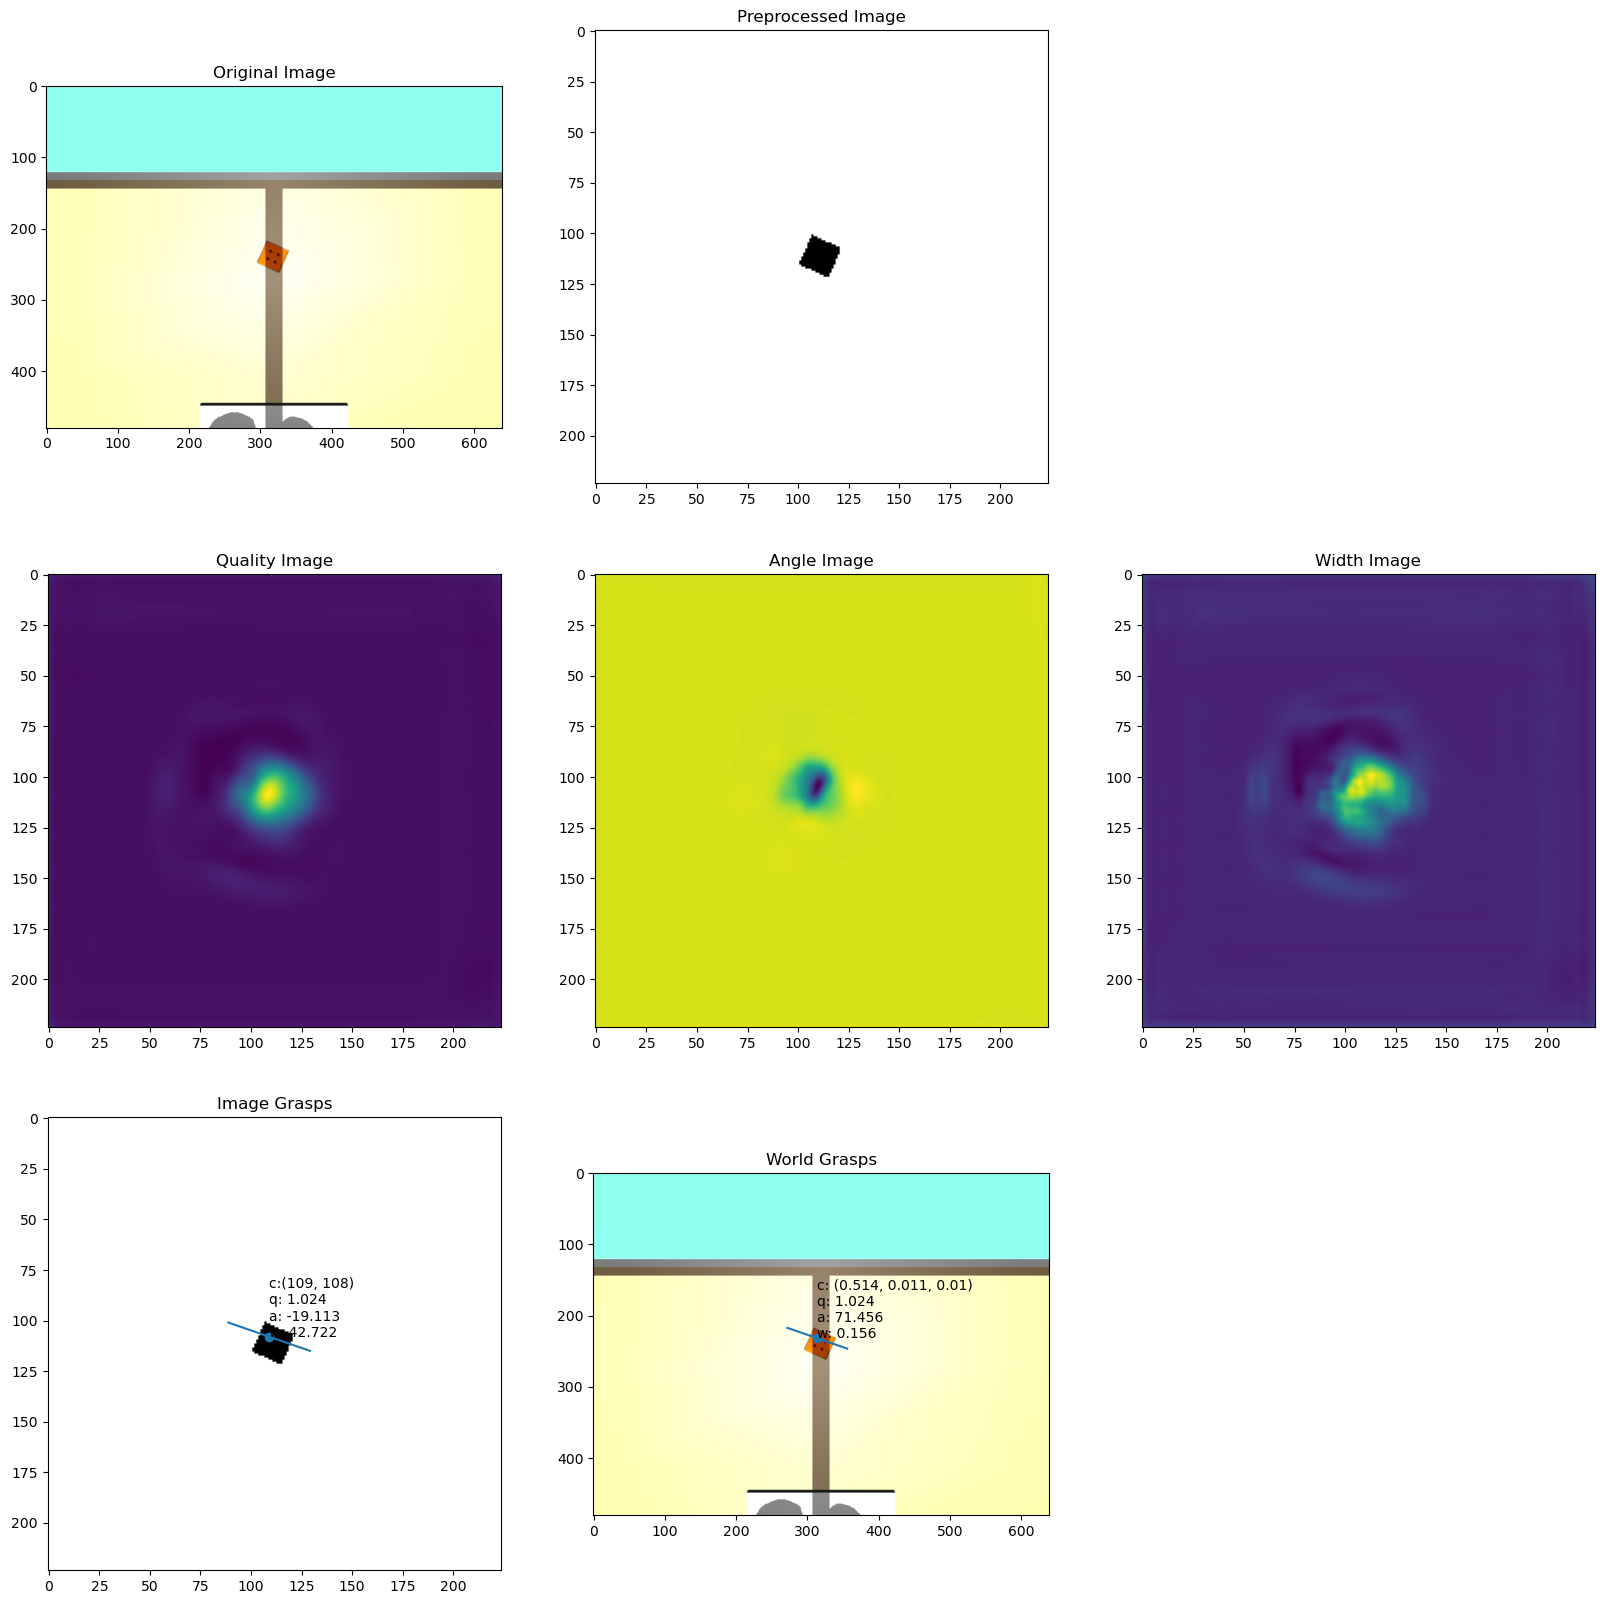

In [8]:
fig = vis.overview_fig(
    fig=plt.figure(figsize=(20, 20)),
    original_rgb=vis.make_tensor_displayable(process_data["sample"].rgb, True, True),
    preprocessed_rgb=vis.make_tensor_displayable(
        process_data["preprocessor"]["rgb_masked"], True, True
    ),
    q_img=vis.make_tensor_displayable(
        process_data["postprocessor"]["q_img"], False, False
    ),
    angle_img=vis.make_tensor_displayable(
        process_data["postprocessor"]["angle_img"], False, False
    ),
    width_img=vis.make_tensor_displayable(
        process_data["postprocessor"]["width_img"], False, False
    ),
    image_grasps=process_data["grasps_img"],
    world_grasps=process_data["grasps_world"],
    cam_intrinsics=cam_intrinsics,
    cam_rot=cam_rot,
    cam_pos=cam_pos,
)

plt.show()